In [100]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
os.add_dll_directory('C:\Aorda\PSG\lib')
import psgpython as psg
import random
import yfinance as yf
%matplotlib inline
from sklearn.svm import NuSVR

allowExternal = True
suppressMessages = True

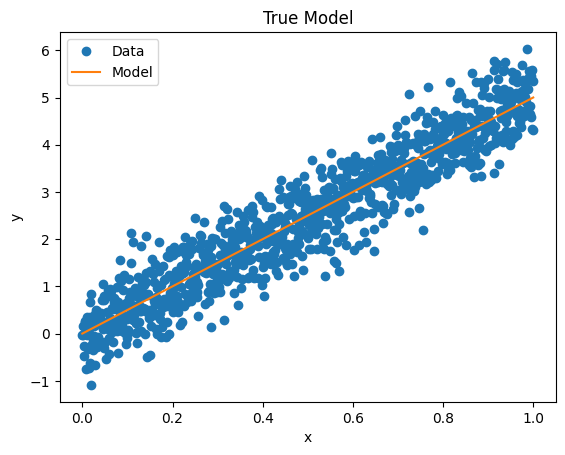

In [101]:
# Simulating Data
N = 1000
#np.random.seed(1)
e = np.random.normal(0,.5, N)  # Laplace Noise
w = 5
x = np.linspace(0,1,N)
b = 0
y = w*x+b
#y = [np.sin(x/100)*x/50 + b for x in range(N)]

# Plotting
plt.plot(x,y+e, 'o', label='Data')
plt.plot(x, y, label='Model')
plt.title('True Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

In [102]:
# Model Parameters
alpha = .999
c = 1
reg = 1/(2*c*N)

# Building Design Matrices
matrix_scenarios_body = np.reshape(x, (N, 1))
scenario_benchmark = y + e
x1 = np.reshape(np.ones(N), (N, 1))  # vector of ones
matrix_scenarios_body = np.column_stack((x1, matrix_scenarios_body, scenario_benchmark))
header_primal = ["x%d" % (i) for i in range(1, matrix_scenarios_body.shape[1])]
matrix_scenarios = [header_primal+['scenario_benchmark'], matrix_scenarios_body]

# Regularization Matrix
matrix_quadratic_body = np.reshape([[0, 0], [0, reg]], (2, 2))
matrix_quadratic = [header_primal, matrix_quadratic_body]

# nu-SVR Problem Statement
allowExternal = True
suppressMessages = False
problem_name_p = "problem_primal"
problem_statement_p = "minimize\n\
%f" % (1-alpha) + "*cvar_risk(" + "%f" % (alpha) + ",abs(matrix_scenarios))\n\
+quadratic(matrix_quadratic)\n\
Value: \n\
var_risk(" + "%f" % (alpha) + ",abs(matrix_scenarios))\n\
Solver: van"
problem_dictionary_primal = {'problem_name': problem_name_p, 'problem_statement': problem_statement_p,
                             'matrix_scenarios': matrix_scenarios, 'matrix_quadratic': matrix_quadratic}

# Optimization Output
res_primal = psg.psg_solver(problem_dictionary_primal, allowExternal, suppressMessages)
# Solution


Running solver
Reading problem formulation
Asking for data information
Getting data
     33.3% of scenarios is processed
100% of abs(matrix_scenarios) was read
100% of matrix_quadratic was read
Start optimization
Ext.iteration=0  Objective=0.602885812793E-02  Residual=0.000000000000E+00
Ext.iteration=41  Objective=0.344119723861E-02  Residual=0.000000000000E+00
Optimization is stopped
Solution is optimal
Calculating resulting outputs. Writing solution.
Objective: objective = 3.441197238611E-03 [9.198371231367E-16]
Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = optimal
Timing: data_loading_time = 0.15, preprocessing_time = 0.01, solving_time = 0.01
Variables: optimal_point = point_problem_1
Objective: objective = 3.441197238611E-03 [9.198371231367E-16]
Function: cvar_risk(0.999,abs(matrix_scenarios)) =  3.324318966258E+00
Function: quadratic(matrix_quadratic) =  1.168782723530E-04
Function: var_risk(0.999,abs(matrix_scenarios)) =  3.324318966258E

In [103]:
primal_coefs_err = res_primal['point_problem_1'][1]
print(f'Optimal coefficients with PSG: \n w = {primal_coefs_err[1]}, b = {primal_coefs_err[0]}')

# VaR for e-SVR to confirm the equivalence
VaR_1 = float(list(res_primal['output'][6].split(" "))[-1])
print(f'Corresponding value-at-risk:\n VaR_alpha = {VaR_1}')

# Python Solver
nusvr_lin = NuSVR(kernel="linear",C=c, gamma="auto", tol=1e-7, nu=1-alpha)
nusvr_lin.fit(np.reshape(x, (N, 1)), scenario_benchmark)

# Solution
nusvr_coef = nusvr_lin.coef_[0][0]
nusvr_intercept = nusvr_lin.intercept_[0]
print(f'Optimal coefficients with Python:\n w = {nusvr_coef}, b = {nusvr_intercept}')

Optimal coefficients with PSG: 
 w = 0.48348375847170644, b = 2.227830951362656
Corresponding value-at-risk:
 VaR_alpha = 3.324318966258
Optimal coefficients with Python:
 w = 0.4834834834834839, b = 2.227831084193122


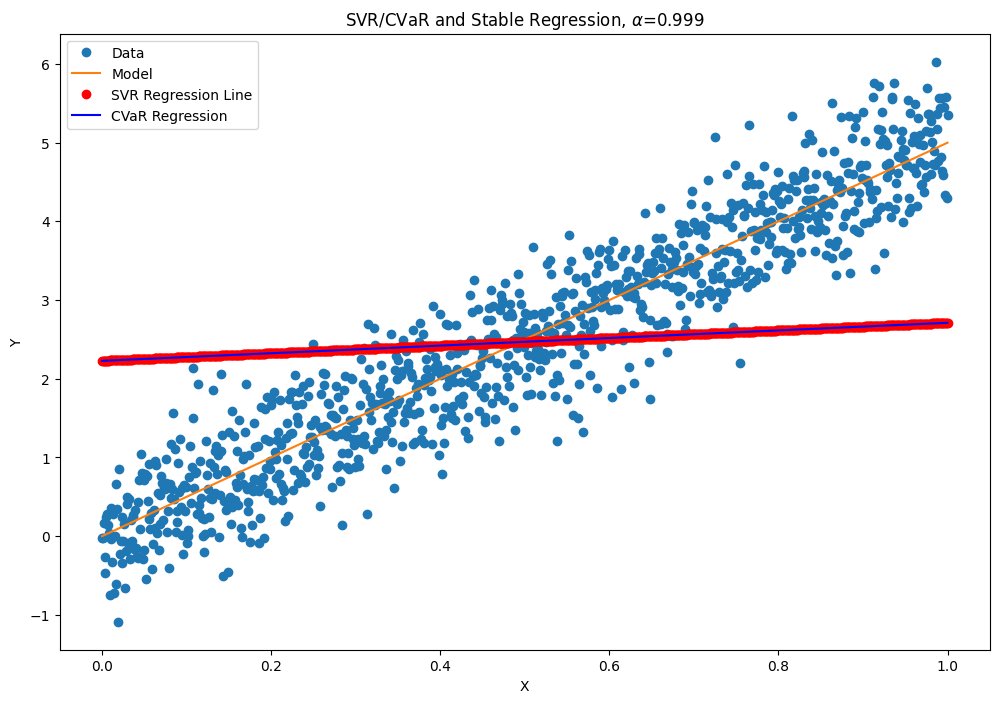

In [104]:
plt.figure(figsize=(12, 8))

plt.plot(x,y+e,'o', label='Data')
plt.plot(x, y, label='Model')
plt.plot(x, nusvr_coef*x+nusvr_intercept,'o', color='red', label='SVR Regression Line')
plt.plot(x, primal_coefs_err[1]*x+primal_coefs_err[0], color='blue', label='CVaR Regression' )


# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'SVR/CVaR and Stable Regression, $\\alpha$={alpha}')
plt.legend()

# Show the plot
plt.show()